# Tennis Player Rank Prediction based on Historical Performance on Indian Wells Tournament

This notebook will explore the task of predicting tennis players rank based on their historical performance and betting data. The scope of the analysis is the Indian Wells tournament with the horizon of six years. The notebook will be organized into several sections, namely data preparation, EDA, dataset splitting, model deployment, model evaluation and end-point deletion.

## Data Preparation

We will begin the data preparation task by following below steps:
1. Importing necessary libraries
2. Creating S3 bucket (to save the models into AWS sagemaker - scaleable)
3. Mapping train and test data in S3 (map the output path of the model on S3)
4. Mapping the path of the models in S3

#### 1. Import Necessary Libraries

In [1]:
# Import necessary libraries

import sagemaker
import boto3 #read the S3 buckets if it's public
from botocore.exceptions import ClientError
import logging
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.amazon.amazon_estimator import get_image_uri

from sagemaker.session import s3_input, Session

#### 2. Create a new S3 bucket

We will now create an S3 bucket directly from the notebook by specifying the bucket name and the region name.

In [2]:
# Specify the bucket name to be created
bucket_name = 'atp-tennis-prediction'

# Use boto3 library to check the region
my_region = boto3.session.Session().region_name # set the region of the instance
print(my_region)

us-west-2


In [3]:
# Create an S3 bucket
# Source: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/s3-example-creating-buckets.html

def create_bucket(bucket_name, region=None):
    """Create an S3 bucket in a specified region

    If a region is not specified, the bucket is created in the S3 default
    region (us-east-1).

    :param bucket_name: Bucket to create
    :param region: String region to create bucket in, e.g., 'us-west-2'
    :return: True if bucket created, else False
    """

    # Create bucket
    try:
        if region is None:
            s3_client = boto3.client('s3')
            s3_client.create_bucket(Bucket=bucket_name)
        else:
            s3_client = boto3.client('s3', region_name=region)
            location = {'LocationConstraint': region}
            s3_client.create_bucket(Bucket=bucket_name,
                                    CreateBucketConfiguration=location)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [4]:
# Call the function to create S3 bucket
create_bucket(bucket_name, my_region)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


True

In [5]:
# Retrieve the list of existing buckets
s3 = boto3.client('s3')
response = s3.list_buckets()

# Output the bucket names
print('Existing buckets:')
for bucket in response['Buckets']:
    print(f'  {bucket["Name"]}')

Existing buckets:
  atp-tennis-prediction


#### 3. Mapping the output path

To be able to perform dataset splitting and a training job, we will need to specify the path in which all the data and models will be stored.

In [6]:
# Set an output path where the trained model will be saved
prefix = 'xgboost-as-a-built-in-algo'
output_path = 's3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://atp-tennis-prediction/xgboost-as-a-built-in-algo/output


#### 4. Web-scrape the Dataset and Save it on S3

As the environment is ready, we can now proceed to extract the data from S3 bucket as well as from the websites.

#### Handling Parquet Files

Here we will extract several parquet files as generated by the first ETL pipeline.

In [7]:
# Reading parquet files
# Source: https://stackoverflow.com/questions/45043554/how-to-read-a-list-of-parquet-files-from-s3-as-a-pandas-dataframe-using-pyarrow

import boto3
import io
import pandas as pd

# Read single parquet file from S3
def pd_read_s3_parquet(key, bucket, s3_client=None, **args):
    if s3_client is None:
        s3_client = boto3.client('s3')
    obj = s3_client.get_object(Bucket=bucket, Key=key)
    return pd.read_parquet(io.BytesIO(obj['Body'].read()), **args)

# Read multiple parquets from a folder on S3 generated by spark
def pd_read_s3_multiple_parquets(filepath, bucket, s3=None, 
                                 s3_client=None, verbose=False, **args):
    if not filepath.endswith('/'):
        filepath = filepath + '/'  # Add '/' to the end
    if s3_client is None:
        s3_client = boto3.client('s3')
    if s3 is None:
        s3 = boto3.resource('s3')
    s3_keys = [item.key for item in s3.Bucket(bucket).objects.filter(Prefix=filepath)
               if item.key.endswith('.parquet')]
    if not s3_keys:
        print('No parquet found in', bucket, filepath)
    elif verbose:
        print('Load parquets:')
        for p in s3_keys: 
            print(p)
    dfs = [pd_read_s3_parquet(key, bucket=bucket, s3_client=s3_client, **args) 
           for key in s3_keys]
    return pd.concat(dfs, ignore_index=True)

#### Retrieve files from URL

As a complementary data, we will also extract the csv outputs from the same website as we have web-scraped in the previous task.

In [9]:
import pandas as pd
import urllib
try:
    urllib.request.urlretrieve ("http://tennis-data.co.uk/{}/indianwells.csv".format('2022'), "{}.csv".format('2022'))
    urllib.request.urlretrieve ("http://tennis-data.co.uk/{}/indianwells.csv".format('2021'), "{}.csv".format('2021'))
    urllib.request.urlretrieve ("http://tennis-data.co.uk/{}/indianwells.csv".format('2019'), "{}.csv".format('2019'))
    urllib.request.urlretrieve ("http://tennis-data.co.uk/{}/indianwells.csv".format('2018'), "{}.csv".format('2018'))
    urllib.request.urlretrieve ("http://tennis-data.co.uk/{}/indianwells.csv".format('2017'), "{}.csv".format('2017'))
    urllib.request.urlretrieve ("http://tennis-data.co.uk/{}/indianwells.csv".format('2016'), "{}.csv".format('2016'))
    print('Success: Data downloaded')
except Exception as e:
    print('Data load error: ',e)

try:
    df_2022 = pd.read_csv('./2022.csv',index_col=0)
    df_2021 = pd.read_csv('./2021.csv',index_col=0)
    df_2019 = pd.read_csv('./2019.csv',index_col=0)
    df_2018 = pd.read_csv('./2018.csv',index_col=0)
    df_2017 = pd.read_csv('./2017.csv',index_col=0)
    df_2016 = pd.read_csv('./2016.csv',index_col=0)
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: Data downloaded
Success: Data loaded into dataframe.


Now, as all the data is ready, we can perform dataframe operations to clean and prepare the data structure.

In [44]:
results = pd.concat([df_2022,df_2021,df_2019,df_2018,df_2017,df_2016],axis=0).reset_index()
results.head(2)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,PSW,PSL,MaxW,MaxL,AvgW,AvgL,EXW,EXL,LBW,LBL
0,19,Indian Wells,BNP Paribas Open,10/03/2022,Masters 1000,Outdoor,Hard,1st Round,3,Bonzi B.,...,2.02,1.89,2.12,1.90,2.03,1.79,NaN,NaN,NaN,NaN
1,19,Indian Wells,BNP Paribas Open,10/03/2022,Masters 1000,Outdoor,Hard,1st Round,3,Fognini F.,...,1.54,2.68,1.54,3.02,1.45,2.76,NaN,NaN,NaN,NaN


#### Summary Statistics and Correlation

First we would like to see the summary statistics and correlation table of the attributes in the dataset.

In [45]:
# Overview of the data type
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 40 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ATP         570 non-null    int64  
 1   Location    570 non-null    object 
 2   Tournament  570 non-null    object 
 3   Date        570 non-null    object 
 4   Series      570 non-null    object 
 5   Court       570 non-null    object 
 6   Surface     570 non-null    object 
 7   Round       570 non-null    object 
 8   Best of     570 non-null    int64  
 9   Winner      570 non-null    object 
 10  Loser       570 non-null    object 
 11  WRank       570 non-null    int64  
 12  LRank       570 non-null    int64  
 13  WPts        570 non-null    int64  
 14  LPts        570 non-null    int64  
 15  W1          561 non-null    float64
 16  L1          561 non-null    float64
 17  W2          558 non-null    float64
 18  L2          558 non-null    float64
 19  W3          193 non-null    f

As we can see the dataset consists of different data types which we need to adjust before model building. In addition, several columns do not have any data at all, which means we can ignore the column altogether.

Below table provides the summary statistics of numerical variable in the dataset.

In [46]:
# Summary statistics
results.describe()

,ATP,Best of,WRank,LRank,WPts,LPts,W1,L1,W2,L2,...,PSW,PSL,MaxW,MaxL,AvgW,AvgL,EXW,EXL,LBW,LBL
count,570.000000,570.0,570.000000,570.000000,570.000000,570.000000,561.000000,561.000000,558.000000,558.000000,...,568.000000,568.000000,570.000000,570.000000,570.000000,570.000000,282.000000,283.000000,283.000000,283.000000
mean,24.833333,3.0,48.868421,69.715789,2153.038596,1401.628070,5.869875,4.065954,5.747312,3.969534,...,2.013979,3.366796,2.067632,3.526895,1.923368,3.081228,1.851312,2.910424,1.933604,3.201095
std,13.055187,0.0,46.065689,65.904041,2440.085677,1521.389348,1.199331,1.801071,1.280548,1.815791,...,1.455699,2.888075,1.492352,3.308058,1.165090,2.219113,1.034361,1.824062,1.335993,2.599607
min,19.000000,3.0,1.000000,1.000000,100.000000,55.000000,0.000000,0.000000,0.000000,0.000000,...,1.010000,1.030000,1.020000,1.040000,1.010000,1.020000,1.010000,1.010000,1.010000,1.020000
25%,19.000000,3.0,14.000000,29.000000,798.500000,663.000000,6.000000,3.000000,6.000000,3.000000,...,1.300000,1.720000,1.312500,1.752500,1.270000,1.670000,1.250000,1.610000,1.285000,1.670000
50%,19.000000,3.0,37.000000,58.000000,1279.500000,920.500000,6.000000,4.000000,6.000000,4.000000,...,1.610000,2.495000,1.650000,2.555000,1.585000,2.355000,1.490000,2.400000,1.530000,2.500000
75%,19.000000,3.0,69.000000,88.000000,2467.500000,1477.250000,6.000000,6.000000,6.000000,6.000000,...,2.260000,3.975000,2.330000,4.087500,2.170000,3.715000,2.187500,3.500000,2.200000,3.750000
max,54.000000,3.0,420.000000,581.000000,16540.000000,12040.000000,7.000000,7.000000,7.000000,7.000000,...,21.330000,29.160000,21.330000,41.500000,14.980000,19.450000,10.500000,12.000000,15.000000,26.000000


To understand the relationship between attributes in the dataset, we will plot all variables into a correlation matrix. Our target variable is "WRank", short for World Rank, which indicates the ranking of a tennis player worldwide. From the correlation table we can see that "WRank" is only mildly correlated with several betting attributes, namely B365W, PSW and EXW.

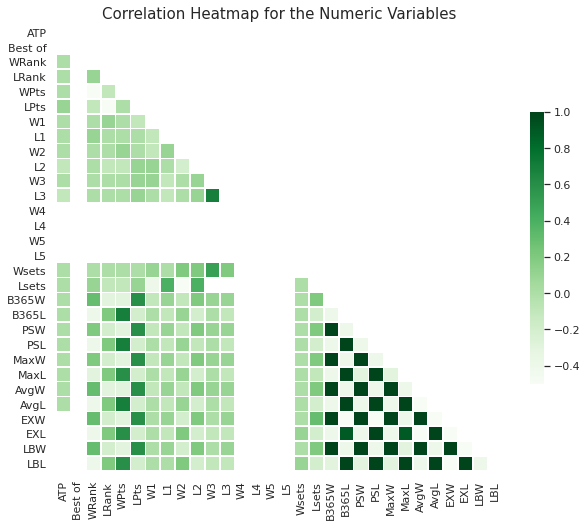

In [47]:
# Correlation table
# Check for multicollinearity

sns.set(style='white') #set the style
corr = round(results.corr(),1) #define the correlation 
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10,10)) #figure size 
cmap = sns.diverging_palette(30,180, as_cmap=True) 
ax = sns.heatmap(corr, mask =mask, cmap="Greens", vmax= 1, annot = False, 
annot_kws= {'size':12}, square=True, xticklabels=True, yticklabels=True, 
linewidths=.6, linecolor='w', cbar_kws={'shrink': 0.5}, ax=ax) #input the ax varibales 
ax.set_title('Correlation Heatmap for the Numeric Variables', fontsize=15); #set the figure title

#### Outlier Detection

To understand the distribution of three most correlated features, we will plot them into three separate histograms to see if there is any outlier present. The result suggests that all betting data are negatively skewed with a long tail towards high scores, which is expected because there should be only a small number of players that acquire a very high bets on tournament average.

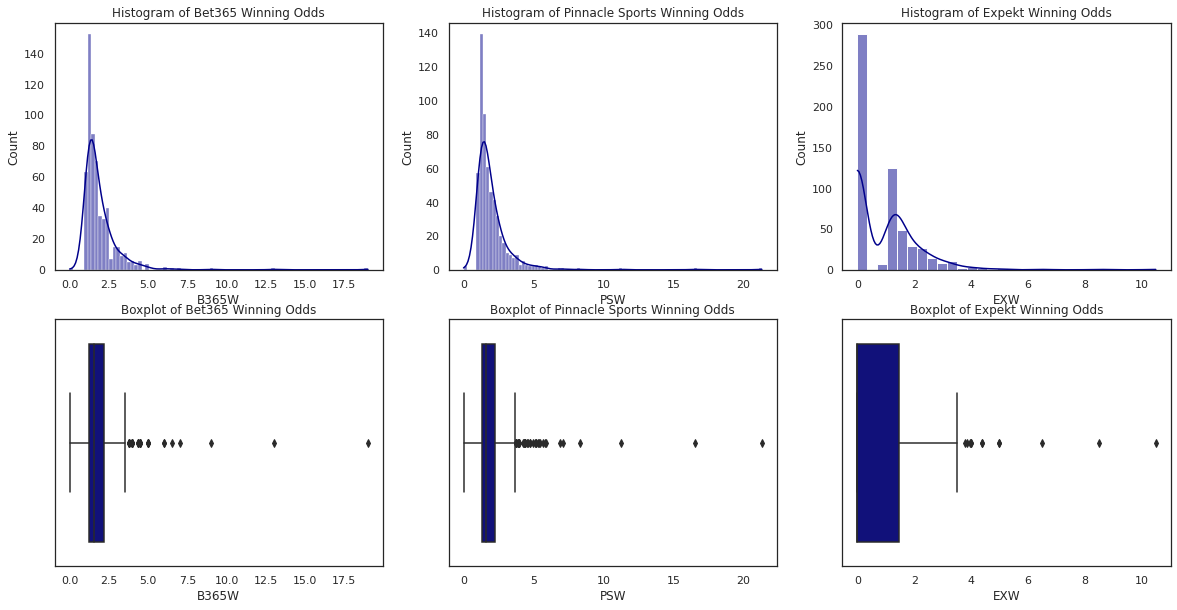

In [113]:
# Create plotting matrix
fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot(231)
ax2 = plt.subplot(232)
ax3 = plt.subplot(233)
ax4 = plt.subplot(234)
ax5 = plt.subplot(235)
ax6 = plt.subplot(236)

# Figure xx. Histogram and Boxplot of upc
hist = sns.histplot(data=results, x="B365W", kde=True, ax=ax1,color=("darkblue"));
hist.set(xlabel='B365W', title="Histogram of Bet365 Winning Odds");
box = sns.boxplot(x="B365W", data = results, ax=ax4,color=("darkblue"));
box.set(xlabel='B365W', title="Boxplot of Bet365 Winning Odds");

# Figure xx. Histogram and Boxplot of birth_year
hist = sns.histplot(data=results, x="PSW", kde=True, ax=ax2,color=("darkblue"));
hist.set(xlabel='PSW', title="Histogram of Pinnacle Sports Winning Odds");
box = sns.boxplot(x="PSW", data = results, ax=ax5,color=("darkblue"));
box.set(xlabel='PSW', title="Boxplot of Pinnacle Sports Winning Odds");

# Figure xx. Histogram and Boxplot of stream_length
hist = sns.histplot(data=results, x="EXW", kde=True, ax=ax3,color=("darkblue"));
hist.set(xlabel='EXW', title="Histogram of Expekt Winning Odds");
box = sns.boxplot(x="EXW", data = results, ax=ax6,color=("darkblue"));
box.set(xlabel='EXW', title="Boxplot of Expekt Winning Odds");

plt.show();

## Exploratory Data Analysis

As the task is to predict the likelihood of a player to be categorized as top 10 world player based on their performance and betting data, we would like to see what is the current distribution of top 10 tennis players in the world.

#### Visualising Top Tennis Players

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


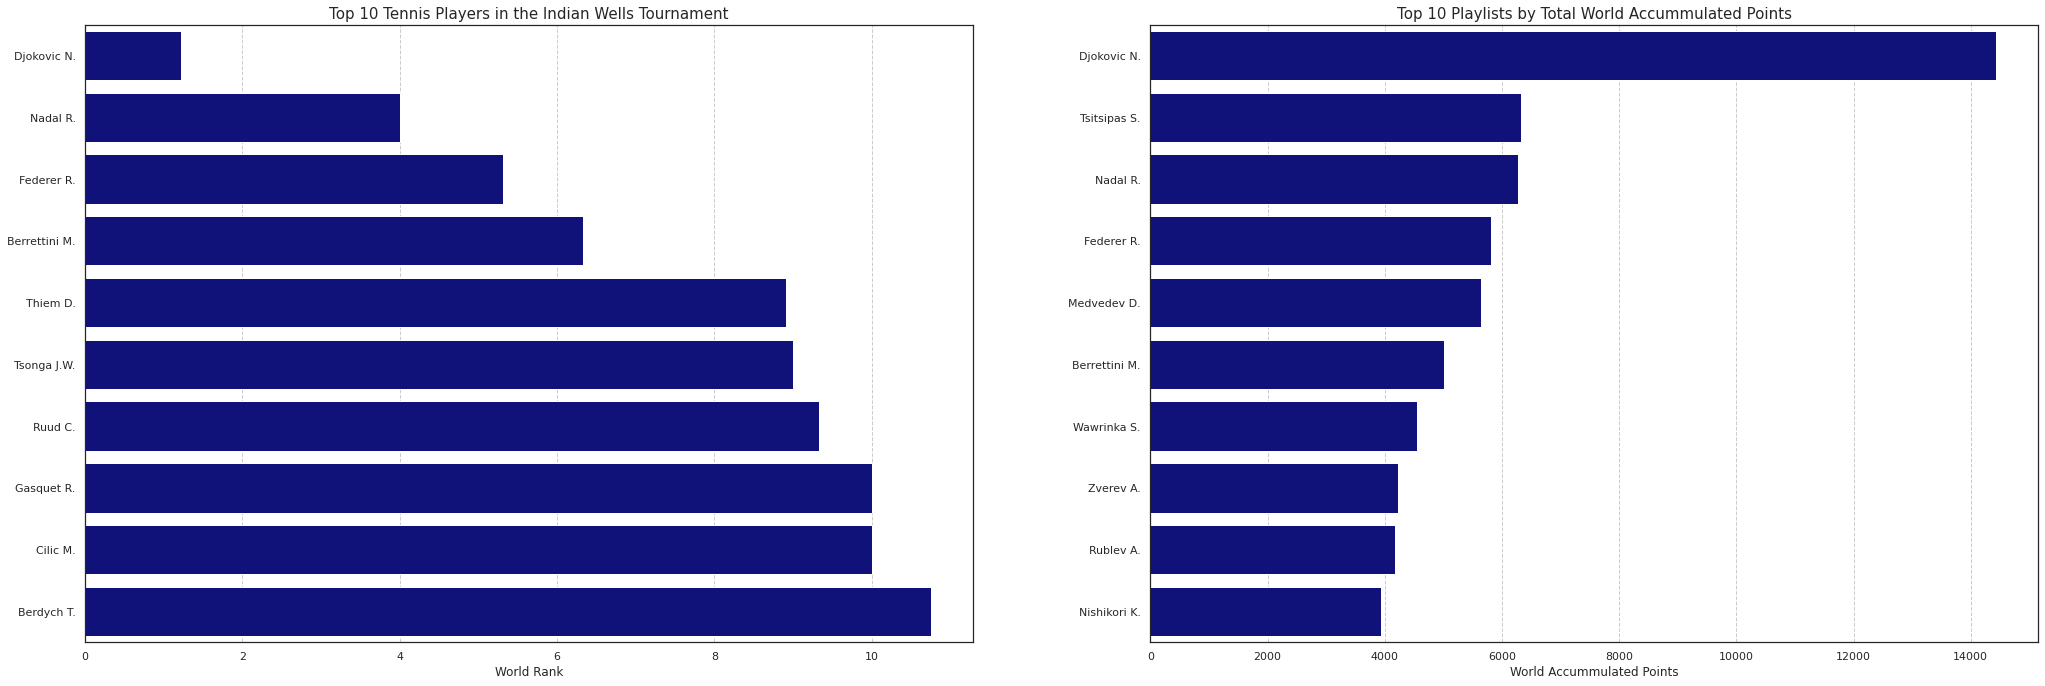

In [48]:
# Create plots
fig = plt.figure(figsize=(35,25))
fig.tight_layout()
ax1 = plt.subplot(221)
plt.grid(axis = 'x',linestyle='--')
ax2 = plt.subplot(222)
plt.grid(axis = 'x',linestyle='--')

# Figure 2. Top 10 Tennis Players in the Indian Wells Tournament
top_players = results.groupby("Winner")["WRank"].mean().sort_values(ascending=True).head(10)
sns.barplot(top_players,top_players.index,color=("darkblue"),ax=ax1)
ax1.set_title('Top 10 Tennis Players in the Indian Wells Tournament', fontsize = 15);
ax1.set_xlabel('World Rank');
ax1.set_ylabel('');

# Figure 3. Top 10 Playlists by Total World Accummulated Points
top_players_points = results.groupby("Winner")["WPts"].mean().sort_values(ascending=False).head(10)
sns.barplot(top_players_points,top_players_points.index,color=("darkblue"),ax=ax2)
ax2.set_title('Top 10 Playlists by Total World Accummulated Points', fontsize = 15);
ax2.set_xlabel('World Accummulated Points');
ax2.set_ylabel('');

In this project, we will aim to predict whether or not a player is included in the Top 10 World's best tennis player or not, hence we would need to setup a binary dependent variable. If a player is included in the top 10, we will tag it as 1, and 0 otherwise.

In [49]:
# Add a new column indicating dependent variable
results['top_10'] = np.where(results['WRank']>=10, 1, 0)

## Dataset Splitting

As the data still contains categorical values, we will temporarily remove this for further analysis.

In [50]:
# Drop values with categorical variable
results = results.drop(['Location','Tournament','Date','Series','Court','Surface','Round','Winner','Loser','Comment'],axis=1)

In [51]:
# Replacing null values with very small value fraction
results = results.fillna(0.001)

#### Split the Dataset

To begin the machine learning model building, we will divide the dataset into train and test data with a proportion of 70:30.

In [52]:
# Train Test split

import numpy as np
train_data, test_data = np.split(results.sample(frac=1, random_state=1729), [int(0.7 * len(results))])
print(train_data.shape, test_data.shape)

(399, 31) (171, 31)


Next, to build the machine learning model, we will split the dataset into two, namely the train and test set with a proportion of 70:30. In this case we disregard the need of using a validation set since the dataset size is too small to be split into three. Each of the train and test set will be saved into a csv format in the pre-defined S3 bucket as created before.

In [53]:
### Saving Train And Test Into Buckets
## We start with Train Data
import os
pd.concat([train_data['top_10'], train_data.drop(['top_10'], 
                                                axis=1)], 
                                                axis=1).to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [2]:
# Test Data Into Buckets
pd.concat([test_data['top_10'], test_data.drop(['top_10'], axis=1)], axis=1).to_csv('test.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
n=60.27
m=73.14
s3_input_test = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/test'.format(bucket_name, prefix), content_type='csv')

In [55]:
# Save the dependent variable
y_train = train_data['top_10']
y_test = test_data['top_10']

## Model Building & Training

With the objective to predict the likelihood of a player to be categorized as top 10 world rank tennis player based on their past performances and betting data, we will be using an built-in algorithm in Amazon Sagemaker, namely the built-in XGBoost algorithm. As the task is a binary logistic regression, we will be using a XGBoost classification algorithm, to be exact.

In [56]:
# This line automatically looks for the XGBoost image URI and builds an XGBoost container.
# Specify the version depending on your preference.

container = get_image_uri(boto3.Session().region_name,
                         'xgboost',
                         repo_version='1.0-1')

#container = sagemaker.image_uris.retrieve(my_region,'xgboost',version='1.0-1')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


The next step is to do hyperparameter tuning, by setting a binary logistic objective and several specific parameters unique to this model.

In [57]:
# Initialize hyperparameters
# Hyperparameter tuning should be donee separately
hyperparameters = {
        "max_depth":"4",
        "eta":"0.2",
        "gamma":"3",
        "min_child_weight":"5",
        "subsample":"0.7",
        "objective":"binary:logistic", # classification using xgboost
        "num_round":50
        }

To call the XGBoost image, we will need to use the sagemaker estimator library, by specifying the parameters, such as the IAM role, train instance count, train instance type, train spot instances and the train run limits. 

In [58]:
# Construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          train_instance_count=1, 
                                          train_instance_type='ml.m4.xlarge', #2x large --> faster
                                          train_volume_size=5, # 5 GB 
                                          output_path=output_path,
                                          train_use_spot_instances=True, # important parameters to limit the building time/reduce the building hours
                                          train_max_run=300, # in seconds
                                          train_max_wait=300)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_use_spot_instances has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_wait has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [59]:
# Input is from the S3 bucket

estimator.fit({'train': s3_input_train,'validation': s3_input_test}) # The input value is the path of the dataset

2022-05-01 11:00:29 Starting - Starting the training job...
2022-05-01 11:00:31 Starting - Launching requested ML instancesProfilerReport-1651402829: InProgress
......
2022-05-01 11:01:59 Starting - Preparing the instances for training............
2022-05-01 11:03:55 Downloading - Downloading input data...
2022-05-01 11:04:30 Training - Training image download completed. Training in progress.
2022-05-01 11:04:30 Uploading - Uploading generated training model.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[11:04:27] 399x30 

## ML Model Deployment

Once the machine learning model is created, we will be able to see a new model created inside the output folder as specified in S3. To deploy the machine learning model, we need to specify the initial instance count (1) and instance type (ml.m4.xlarge).

In [60]:
xgb_predictor = estimator.deploy(
            initial_instance_count=1,
            instance_type='ml.m4.xlarge')

-------!

**Prediction of the Test Data**

Before doing the prediction, we need to import a library called CSV serializer. This is because, before passing a dataset into an endpoint the dataset needs to be serialized for the model to process.

In [98]:
# Import a library to serialize a tabular dataset to be passed to the model
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer

# Drop the dependent feature from test data and convert into an array
test_data_array = test_data.drop(['top_10'], axis=1).values #load the data into an array

In [99]:
# Use .content_type everytime we use csv_serializer
xgb_predictor.CONTENT_TYPE = 'text/csv' # set the data type for an inference
xgb_predictor.serializer = CSVSerializer() # set the serializer type
# xgb_predictor.deserializer = None

In [100]:
# Extract the endpoint of current predictor
# The result will be an input for the lambda function

xgb_predictor.endpoint

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


'sagemaker-xgboost-2022-05-01-11-05-13-070'

#### Predicting Test Data

After being serialized, we also need to attach a decoding operator to convert the result into (utf-8) format, as the prediction output will be presented in an encoded format.

In [101]:
# Predict the test data
# Decoding is required because when we are doing the prediction, the format was encoded, so we need to decode
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!


In [102]:
# Take the first part of the particular data
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

(171,)


In [103]:
predictions_array

array([0.98708832, 0.98708832, 0.98708832, 0.98708832, 0.98708832,
       0.98708832, 0.98708832, 0.09630252, 0.98708832, 0.09630252,
       0.98708832, 0.98708832, 0.98708832, 0.98708832, 0.15665884,
       0.09630252, 0.98708832, 0.98708832, 0.98708832, 0.98708832,
       0.98708832, 0.98708832, 0.98708832, 0.98708832, 0.98708832,
       0.98708832, 0.98708832, 0.98708832, 0.98708832, 0.98708832,
       0.09630252, 0.98708832, 0.9152841 , 0.09630252, 0.98708832,
       0.98708832, 0.98708832, 0.98708832, 0.09630252, 0.97050148,
       0.98708832, 0.88296378, 0.98708832, 0.98708832, 0.98708832,
       0.98708832, 0.98708832, 0.09630252, 0.98708832, 0.98708832,
       0.09630252, 0.09630252, 0.09630252, 0.98708832, 0.98708832,
       0.98708832, 0.98708832, 0.09630252, 0.98708832, 0.98708832,
       0.98708832, 0.98708832, 0.09630252, 0.98708832, 0.09630252,
       0.09630252, 0.98708832, 0.98708832, 0.98708832, 0.98708832,
       0.98708832, 0.98708832, 0.98708832, 0.98708832, 0.98708

In [108]:
# Sample input parameter for prediction
result = float(xgb_predictor.predict([[19,3,78,71,800,861,4,6,7,5,7,6,0,0,0,0,2,1,2.37,1.57,2.49,1.6,2.5,1.6,2.39,1.57,6.5,1.08,7.5,1.08]]).decode('utf-8'))

if result >= 0.9:
    print('The player is part of Top 10 World Rank')
else:
    print('The player is not part of Top 10 World Rank')

The player is part of Top 10 World Rank


## Model Evaluation

#### Confusion Matrix for the Classification Task

To evaluate the performance of the XGBoost classification model, we will create a confusion matrix to show the precision and recall scores of the model. In this case, the overall F1 score of the XGBoost model is 63.9%.

In [104]:
# Creating a confusion matrix

# Crosstab 
cm = pd.crosstab(index=test_data['top_10'], columns=np.round(predictions_array), rownames=['Observed'], colnames=['Predicted'])
tn = cm.iloc[0,0]; fn = cm.iloc[1,0]; tp = cm.iloc[1,1]; fp = cm.iloc[0,1]; p = (tp+tn)/(tp+tn+fp+fn)*(n+m/20)
print("\n{0:<20}{1:<4.1f}%\n".format("Overall Classification Rate: ", p))
print("{0:<15}{1:<15}{2:>8}".format("Predicted", "Not in the Top 20", "In the Top 20"))
print("Observed")

# Based on the purchase/no purchase, check the classification matrix
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("Not in the Top 20   ", tn/(tn+fn)*n,tn, fp/(tp+fp)*n, fp))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("In the Top 20        ", fn/(tn+fn)*m,fn, tp/(tp+fp)*m, tp))


Overall Classification Rate: 63.9%

Predicted      Not in the Top 20In the Top 20
Observed
Not in the Top 20   60% (31)     0% (0)
In the Top 20        0% (0)     73% (140) 



## Deleting the End Points

One of the most important things after running any model in Sagemaker is to delete the endpoints. This is to ensure that there are no inferences that are still running in the background. Below code will help to delete all endpoints, inferences and the buckets.

In [ ]:
# Delete endpoints of the estimator
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)

# Specify bucket to delete
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)

# Everything will be deleted
bucket_to_delete.objects.all().delete()

## Appendix

### Lambda Function (to be included in Lambda function)

In [ ]:
import os
import io
import boto3
import json

# grab environment variables
ENDPOINT_NAME = os.environ['ENDPOINT_NAME']
runtime= boto3.client('runtime.sagemaker')

def lambda_handler(event, context):
    print("Received event: " + json.dumps(event, indent=2))
    
    data = json.loads(json.dumps(event))
    payload = data['data']
    print(payload)
    
    response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                       ContentType='text/csv',
                                       Body=payload)
    print(response)
    result = json.loads(response['Body'].read().decode())
    pred = 'The player is part of Top 10 World Rank' if result >= 0.9 else 'The player is not part of Top 10 World Rank'
    print(pred)
    return pred

### Configure Test Setting (to be included in Lambda function)

In [110]:
{
    "data": "
        19,3,78,71,800,861,4,6,7,5,7,6,0,0,0,0,2,1,2.37,1.57,2.49,1.6,2.5,1.6,2.39,1.57,6.5,1.08,7.5,1.08
        "
}